<a href="https://colab.research.google.com/github/bayashi-cl/statistical-learning/blob/working/note/03_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols


sns.set()

In [ ]:
ad = pd.read_csv("https://www.statlearning.com/s/Advertising.csv", index_col=0)

In [14]:
X = ad['TV'].to_numpy()
Y = ad['sales'].to_numpy()
x_bar = X.mean()
y_bar = Y.mean()
n = len(X)

# 3 線形回帰

[スライド](https://web.stanford.edu/~hastie/ISLR2/Slides/Ch3_Linear_Regression.pdf)

線形回帰の特徴
* 教師あり学習
* シンプル
* 定量的な予測に強い

今後に出てくる学習の手法は線形回帰を発展させたものが多い。

`Advertising`のデータからマーケティングプランを提案するにはどのような情報が必要だろうか。

以下のような問題について考える。

1. そもそも広告費と売上の間に関係性はあるか。
1. その関係はどれくらい強いのか。
1. どのメディアがどれだけ売上に貢献しているか。
1. 売上の予測はどれくらい正確か。
1. 関係性は線形か。
1. メディア間の相乗効果は存在するのか。



## 3.1 単回帰

単回帰では $Y$ を目的変数、 $X$ を説明変数として、

$$Y \approx \beta_0 + \beta_1X$$

のようなモデルを考える。例えば`sales`と`TV`の関係なら、

$$\textrm{sales} \approx \beta_0 + \beta_1 \times \textrm{TV}$$

として $\hat{\beta}$ を求める。


### 3.1.1 パラメータの推定

まずは**最小二乗法**で考える（他の考え方は6章で）。

$\hat{y}_i = \hat{\beta_0}+\hat{\beta_1}x_i$ を $i$ 番目のデータに対する推定値として残差を $e_i = y_i - \hat{y_i}$ とする。

ここで**残差平方和**(*residual sum of squares (RSS)*)を

$$\textrm{RSS} = e_1^2+ \cdots + e_n^2$$

と定義してこれを最小化すると、

$$
\begin{aligned}
  \hat{\beta_1} &= \frac{\sum_{i=1}^n(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^n(x_i-\bar{x})^2}\\
  \hat{\beta_0} &= \bar{y}-\hat{\beta_1}\bar{x}
\end{aligned}
$$

となる。

実際に計算をする

In [2]:
numerator = 0.0
denominator = 0.0

for xi, yi in zip(X, Y):
  numerator += (xi - x_bar) * (yi - y_bar)
  denominator += (xi - x_bar)**2

beta_hat_1 = numerator / denominator
beta_hat_0 = y_bar - beta_hat_1 * x_bar

min_rss = 0.0
for xi, yi in zip(X, Y):
  yi_hat = beta_hat_0 + beta_hat_1 * xi
  min_rss += (yi - yi_hat)**2


print(f"sales   = {beta_hat_0:.5f} + {beta_hat_1:.5f} * TV")
print(f"min RSS = {min_rss:.5f}")

sales   = 7.03259 + 0.04754 * TV
min RSS = 2102.53058


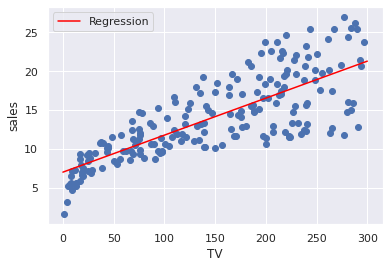

In [3]:
fig, ax = plt.subplots()
ax.scatter(ad['TV'], ad['sales'])
reg_x = np.linspace(0, 300, 100)
reg_y = beta_hat_0 + beta_hat_1 * reg_x
ax.plot(reg_x, reg_y, color="red", label="Regression")
ax.set(xlabel="TV", ylabel="sales")
ax.legend()
plt.show()

In [29]:
sz = 50
b0_ = np.linspace(beta_hat_0 - 2, beta_hat_0 + 2, sz)
b1_ = np.linspace(beta_hat_1 - 0.02, beta_hat_1 + 0.02, sz)
b0, b1 = np.meshgrid(b0_, b1_, indexing='xy')
rss = np.zeros((sz, sz))

for (i, j), _ in np.ndenumerate(rss):
    rss[i, j] = ((Y - (b0[i, j] + X * b1[i, j]))**2).sum()

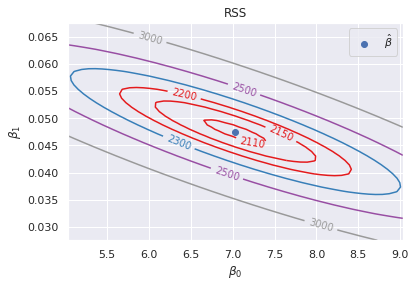

In [31]:
fig, ax = plt.subplots()
cont = ax.contour(b0, b1, rss, cmap=plt.cm.Set1, levels=[2110, 2150, 2200, 2300, 2500, 3000])
cont.clabel(fmt='%1.0f', fontsize=10)
ax.scatter(beta_hat_0, beta_hat_1, label=r"$\hat{\beta}$")
ax.set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="RSS")
ax.legend()
plt.show()

### 3.1.2 推定値の制度の評価

母集団に対してこのモデルをあてはめると $X$ と $Y$の関係は

$Y = \beta_0 + \beta_1X + \epsilon$

この式は**母集団回帰線** *(population regression line)* と呼ばれ、誤差項 $\epsilon$ はこのモデルで見逃している要素（他の変数や観測誤差など）を表す。

最小二乗法による推定は母集団回帰線に一致するとは限らないが、不偏性があるので観測を繰り返せば正確になっていく。

$\hat{\beta_0}$ と $\hat{\beta_1}$ の分散はそれぞれ、

$$
\textrm{SE}(\hat{\beta_0})^2 = \sigma^2\left[ \frac{1}{n}+\frac{\bar{x}^2}{\sum_{i=1}^n(x_i-\bar{x})^2}\right]
$$

$$
\textrm{SE}(\hat{\beta_1})^2 = \frac{\sigma^2}{\sum_{i=1}^n(x_i-\bar{x})^2}
$$

厳密には誤差 $\epsilon$ が共通の分散を持ち独立である必要があるが、そうでなくても近似として有効である。

$x$がバラけていたほうが$\hat{\beta_1}$ の分散が小さくなり、少ないデータで正確な推定ができるようになる。

$\sigma^2$ は未知だが、データから推定することができ、その推定量 $\textrm{RSE} = \sqrt{\textrm{RSS}/(n-2)}$ を**残差標準偏差** *(residual standard error)* と呼ぶ 

標準偏差は信頼区間の推定にも使うことができ、その95%信頼区間はそれぞれ

$$\hat{\beta_1} \pm 2 \cdot \textrm{SE}(\hat{\beta_1})$$
$$\hat{\beta_0} \pm 2 \cdot \textrm{SE}(\hat{\beta_0})$$

で構成される。


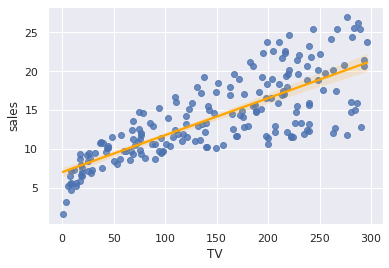

In [11]:
sns.regplot(data=ad, x="TV", y="sales", line_kws={'color': 'orange'})
plt.show()

$X$ と $Y$ に関係性があるかは次の検定により確認できる。

$$
H_0:\beta_1 = 0\\
H_1:\beta_1 \ne 0
$$

t統計量が標準偏差のばらつきを無視できるほど大きければ帰無仮説をrejectできる。

In [9]:
result = ols(formula='sales ~ TV', data=ad).fit()
print(result.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.610    
Dependent Variable: sales            AIC:                1042.0913
Date:               2021-11-28 14:30 BIC:                1048.6880
No. Observations:   200              Log-Likelihood:     -519.05  
Df Model:           1                F-statistic:        312.1    
Df Residuals:       198              Prob (F-statistic): 1.47e-42 
R-squared:          0.612            Scale:              10.619   
--------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept     7.0326     0.4578   15.3603   0.0000   6.1297   7.9355
TV            0.0475     0.0027   17.6676   0.0000   0.0422   0.0528
------------------------------------------------------------------
Omnibus:              0.531         Durbin-Watson:           1.935
Pro

### 3.1.3 モデルの精度を評価する

モデルがデータにどれくらいフィットしているかを知りたい。

通常、**$R^2$統計量**と**残差標準誤差** *residual standard error (RSE)* で評価される。

#### 残差標準誤差

大雑把に言うと、RSEと真の回帰直線から予測値が平均してどれだけ離れているかを表す数値であり、次の式で表される。

$$\textrm{RSE} = \sqrt{\frac{1}{n-2}\textrm{RSS}}$$


In [19]:
rse = sqrt(1 / (n - 2) * min_rss)
print(f"RSE = {rse:.5f}")

RSE = 3.25866


#### $R^2$統計量

RSEは単位が $Y$ に依存するのでそれによらない統計量が欲しい。

$$R^2 = \frac{\textrm{TSS}-\textrm{RSS}}{\textrm{TSS}} = 1-\frac{\textrm{RSS}}{\textrm{TSS}}$$

ここで、$\textrm{TSS}=\sum(y_i-\bar{y})^2$ は**全平方和** *(total sum of squares)*

RSSが回帰を行った後の予測のばらつきを表すのに対して、TSSは回帰を行う前のばらつきを表す。よって $R^2$ 統計量は回帰によりどれだけのばらつきが除去されたかを表し、1に近いほどより多くの要素が回帰によって説明されたことになる。

単回帰の場合は$R^2$統計量は相関係数の2乗と一致するが、次の重回帰では有用である。

In [27]:
corr2 = np.corrcoef(X, Y)[1, 0]**2
print(f"corr^2 = {corr2:.5f}")

corr^2 = 0.61188


## 3.2 重回帰

単回帰を拡張し、次のようなモデルを考える。

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p + \epsilon$$

`Advertising`の例では次のようになる。

$$\textrm{sales} = \beta_0 + \beta_1\times\textrm{TV} + \beta_2\times\textrm{radio} + \beta_3\times\textrm{newspaper} + \epsilon$$



### 3.2.1 回帰係数の推定

単回帰の場合を自然に拡張して推定が可能。

得られる係数は他の要素を固定した状態での変化量。

In [21]:
result_newspaper = ols(formula='sales ~ newspaper', data=ad).fit()
print(result_newspaper.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.047    
Dependent Variable: sales            AIC:                1220.6714
Date:               2021-11-28 15:34 BIC:                1227.2680
No. Observations:   200              Log-Likelihood:     -608.34  
Df Model:           1                F-statistic:        10.89    
Df Residuals:       198              Prob (F-statistic): 0.00115  
R-squared:          0.052            Scale:              25.933   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept      12.3514    0.6214  19.8761  0.0000  11.1260  13.5769
newspaper       0.0547    0.0166   3.2996  0.0011   0.0220   0.0874
------------------------------------------------------------------
Omnibus:               6.231        Durbin-Watson:           1.983
Prob(Omn

In [20]:
result_multi = ols(formula='sales ~ TV + radio + newspaper', data=ad).fit()
print(result_multi.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.896   
Dependent Variable: sales            AIC:                780.3622
Date:               2021-11-28 15:31 BIC:                793.5555
No. Observations:   200              Log-Likelihood:     -386.18 
Df Model:           3                F-statistic:        570.3   
Df Residuals:       196              Prob (F-statistic): 1.58e-96
R-squared:          0.897            Scale:              2.8409  
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
Intercept       2.9389    0.3119   9.4223  0.0000   2.3238  3.5540
TV              0.0458    0.0014  32.8086  0.0000   0.0430  0.0485
radio           0.1885    0.0086  21.8935  0.0000   0.1715  0.2055
newspaper      -0.0010    0.0059  -0.1767  0.8599  -0.0126  0.0105
--------------------

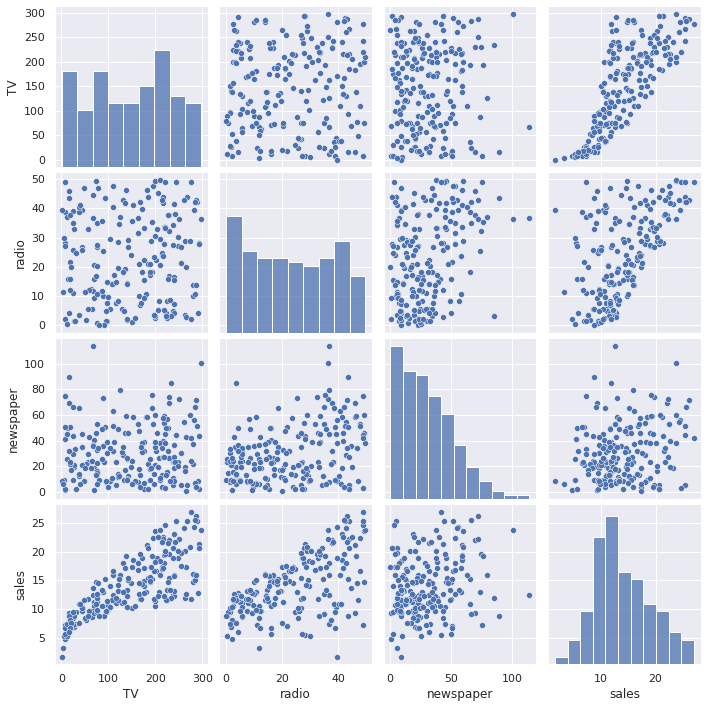

In [23]:
sns.pairplot(data=ad)
plt.show()

In [28]:
ad.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


`newspaper`に注目すると、単回帰では売上との関係が認められるが、重回帰では認められないという結果になっている。重回帰による結果が正しいと仮定し`radio`と`newspaper`の相関係数が大きいことに注目すると、`radio`が大きいと`sales`も`newspaper`も大きくなるという疑似相関が見えてくる。

### 3.2.2 いくつかの重要な疑問

1. 説明変数 $X_1, X_2, \ldots, X_p$のうち有用なものは存在するのか。
1. すべての予測変数がYを説明するのに役立つか，一部の予測変数だけが有用なのか
1. モデルはどのくらいデータに適合しているか？
1. 説明変数のセットが与えられた場合、どのような推定をすべきか。そして、その推定はどのくらい正確か。



#### 説明変数と推定値に関係はあるか

以下の検定を考える

$H_0:\beta_1 = \cdots = \beta_p = 0$ v.s. $H_1:$ 少なくとも1つの $\beta_j$ が非ゼロ

f統計量を使う。

$$F = \frac{(\textrm{TSS}-\textrm{RSS})/p}{\textrm{RSS}/(n-p-1)}$$

帰無仮説が正しければ $E[(\textrm{TSS}-\textrm{RSS})/p] = \sigma^2$ となり、$F$ は1に近い値になる。一方、対立仮説が正しければ $E[\textrm{RSS}/(n-p-1)] = \sigma^2$ となり、 $E[(\textrm{TSS}-\textrm{RSS})/p] > \sigma^2$ となるため、$F$ は1よりも大きい値になる。

棄却域は $n$ と $p$ に依存する。詳しくは現代数理統計学の11.3節へ

`Advertising`ではF統計量が1よりも非常に大きいことから、少なくとも1つのメディアが売上増加と関連しているという極めて強い証拠が得られる。

説明変数が多いとp値を個別に見ただけではそれが偶然小さい値をとっているだけの可能性があるが、F統計量は説明変数の数を調整しているため、そのような問題が発生しない。

$p>n$ の場合にはそもそも最小二乗法が使えないため、前方選択や6章に出てくる手法を使うことになる。

#### どの変数が重要か

大抵の場合、全ての説明変数が目的変数に関係しているわけではない。理想的には全てのモデルを作り、比較することで **変数選択** を行う必要がある。比較の際に基準となる統計情報については
* 赤池情報量基準(AIC)
* ベイズ情報量基準(BIC)
* adjusted $R^2$

などがある。 

しかし、この方法では $2^p$ 個のモデルを作ることになり、嬉しくない。よって効率化が必要である。

古典的には以下のような手法がある。

##### 前方選択
切片のみの状態から、単回帰を行いRSSが小さい順に変数を貪欲に追加していく。余分な変数を含んでしまうことがある。

##### 後方選択
全ての変数が選択された状態からp値が大きい順に除去していく。$p>n$ のときは使えない。

##### 混合選択
前方選択を行い、p値が一定値を上回った場合にその変数を除去する。
